### 説明
本ノートブックは、cfrnetの追実験を行った結果をまとめるためのノートブックである。  
1. 人工データを自前で作成して使用した場合
2. 論文で使用されているIHDPを使用した場合  

の結果を確認する。

In [2]:
import warnings
warnings.filterwarnings('error')
import pandas as pd
import numpy as np
from load_data import IHDP_Dataset, ArtificialData
from model import CFR
from optimize import MMD
from matplotlib import pyplot as plt
import dowhy

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam

In [14]:
def train(cfr_net, train_loader, learning_rate=1e-2, alpha=0.1, seed=0):
    optimizer_w = Adam(cfr_net.representation.parameters(), lr=learning_rate)
    optimizer_v = Adam(cfr_net.hypothesis.parameters(), lr=learning_rate, weight_decay=0.9)

    mmd = MMD()
    mse = torch.nn.MSELoss()
    train_losses = []
    test_losses = []

    def weighted_mse(yf_estimate, yf_true, w):
        return torch.mean(w * (yf_estimate - yf_true)**2)
    
    def loss(yf_estimate, yf_true, t, r_control, r_treat):
        return weighted_mse(yf_estimate, yf_true, t) + alpha * mmd(r_control, r_treat)

    torch.random.manual_seed(10)
    for epoch in range(100):
        for batch in train_loader:
            optimizer_w.zero_grad()
            optimizer_v.zero_grad()
            x_batch, t_batch, w_batch = batch['x'], batch['t'], batch['w']
            r_batch, yf_estimate_batch = cfr_net(x_batch, t_batch)

            # IPM項の勾配
            treat_idx = torch.where(t_batch == 1)
            control_idx = torch.where(t_batch == 0)
            # NOTE: Wassersteinを使うときはこの行を変更する。

            # FIXME: 重み係数行列をLに乗算する必要がある。
            yf_batch = batch['yf']
            if yf_estimate_batch.dim() == 2:
                yf_batch = yf_batch[:, None]
            L = loss(yf_estimate_batch, yf_batch, w_batch, r_batch[control_idx], r_batch[treat_idx])
            L.backward()
            train_losses.append(L.item())
            optimizer_w.step()
            optimizer_v.step()
    return cfr_net, train_losses, test_losses

### 人口データを用いた実験

In [3]:
def view_causality_data_and_result(D, net, losses, legend=True):
    with torch.no_grad():
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

        ax1.set_title('potential outcomes')
        ax1.set_ylabel('$y$')
        ax1.set_xlabel('$x$')
        ax1.plot(D.x, D.mu0, label='$mu_0$', color='blue')
        ax1.plot(D.x, D.mu1, label='$mu_1$', color='orange')

        tau = D.mu1 - D.mu0
        N = D.x.shape[0]
        tau_hat = net(D.x, torch.ones(N))[1] - net(D.x, torch.zeros(N))[1]
        ax2.set_ylabel('effect')
        ax2.set_xlabel('$x$')
        ax2.set_title('ground vs estimate for effect')
        ax2.plot(D.x, tau, color='blue', label='ground')
        ax2.plot(D.x, tau_hat, color='orange', label='predict')

        ax3.set_title('train loss')
        ax3.set_ylabel('loss')
        ax3.set_xlabel('steps')
        ax3.plot(losses)
        
        if legend:
            fig.legend()
        fig.tight_layout()
        plt.show()

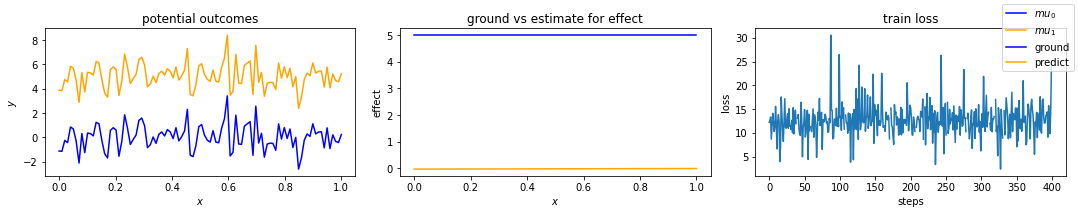

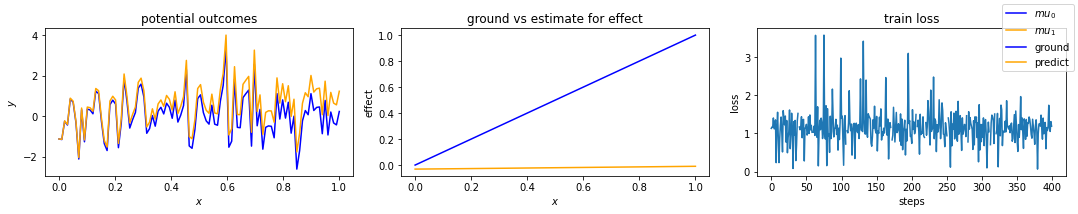

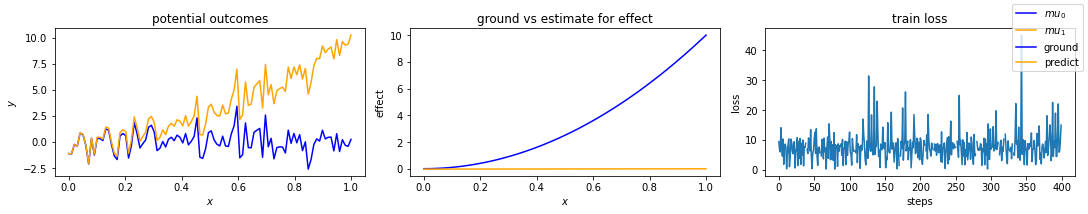

In [15]:
for mode in [0, 1, 2]:
    ad_train_D = ArtificialData(mode=mode, N=1000)
    train_loader = DataLoader(ad_train_D, batch_size=32, shuffle=True)
    cfr_net = CFR(feature_dim=1)
    model, train_losses, _ = train(cfr_net, train_loader, learning_rate=1e-14)
    view_causality_data_and_result(ad_train_D, model, train_losses)

### IHDPデータセットを用いた実験

number of batch:  21


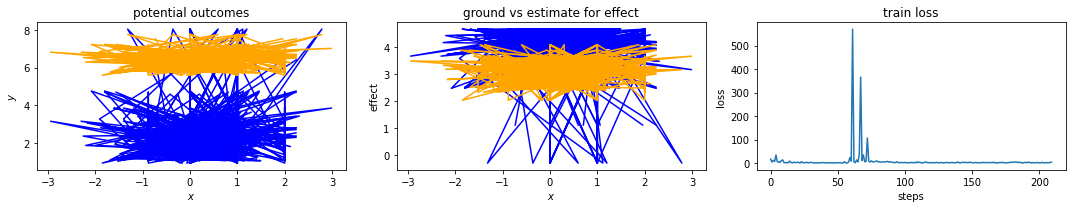

In [13]:
# データの読み込み
train_D = IHDP_Dataset(train=True)
train_loader = DataLoader(train_D, batch_size=32, shuffle=True)
test_D = train_D = IHDP_Dataset(train=False)
print('number of batch: ', len(train_loader))
x = train_D.x
cfr_net = CFR(feature_dim=x.shape[1])
model, train_losses, _ = train(cfr_net, train_loader)
view_causality_data_and_result(train_D, model, train_losses, legend=False)